# Training Neural Network with Single Image
#### 한장의 이미지로 네트워크 학습시키기

## Prepare Data h5py file

한장의 이미지에서 여러장의 데이터를 뽑아오는 연습을 해봅시다. 우선 학습에 사용하고 싶은 이미지를 읽어줍니다. 

In [1]:
import PIL.Image as pil_image
import numpy as np
import matplotlib.pyplot as plt
import h5py
import argparse
import glob
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '1'

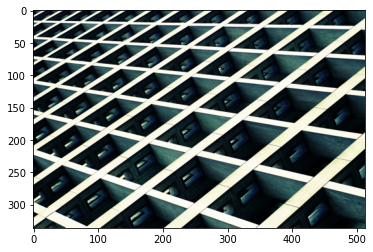

In [2]:
image_path = 'input/butterfly.png'
hr = pil_image.open(image_path).convert('RGB')
plt.imshow(hr)
plt.show()

우선 이미지를 학습 scale에 맞춰주기 위해 mode crop 을 진행해줍니다.

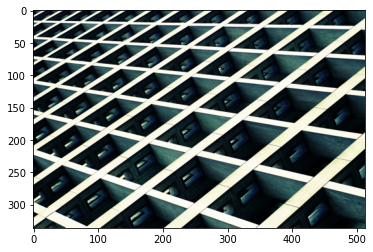

In [3]:
scale = 4
hr_width = (hr.width // scale) * scale
hr_height = (hr.height // scale) * scale
hr = hr.crop((0,  0, hr_width, hr_height))
plt.imshow(hr)
plt.show()

이제 이 이미지가 hr_father 역할을 할 것입니다. 그러면 이 이미지의 해상도를 줄여서 lr_son 역할을 할 이미지를 만들어봅시다. 
</br> 이미지가 약간 blurry 해진 것을 볼 수 있습니다.

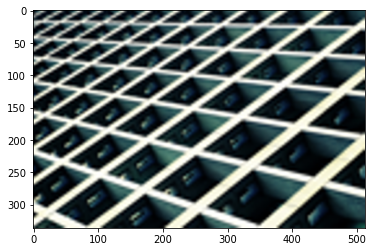

In [4]:
lr = hr.resize((hr_width // scale, hr_height // scale), resample=pil_image.BICUBIC)
lr = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
plt.imshow(lr)
plt.show()

이제 이미지에서 이미지 patch를 뽑아봅시다.

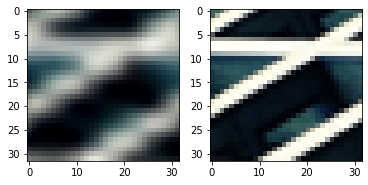

In [5]:
patch_size = 32
hr_numpy = np.array(hr).astype(np.float32)/255.
lr_numpy = np.array(lr).astype(np.float32)/255.

i = 10
j = 20
lr_patch=lr_numpy[i:i + patch_size, j:j + patch_size, :]
hr_patch=hr_numpy[i:i + patch_size, j:j + patch_size, :]

plt.subplot(1,2,1)
plt.imshow((lr_patch*255).astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow((hr_patch*255).astype(np.uint8))
plt.show()

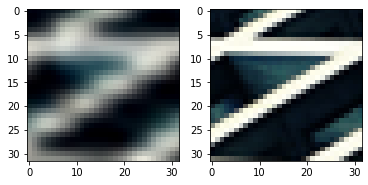

In [6]:
i = 10
j = 10
lr_patch=lr_numpy[i:i + patch_size, j:j + patch_size, :]
hr_patch=hr_numpy[i:i + patch_size, j:j + patch_size, :]

plt.subplot(1,2,1)
plt.imshow((lr_patch*255).astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow((hr_patch*255).astype(np.uint8))
plt.show()

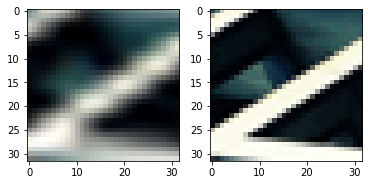

In [7]:
i = 50
j = 50
lr_patch=lr_numpy[i:i + patch_size, j:j + patch_size, :]
hr_patch=hr_numpy[i:i + patch_size, j:j + patch_size, :]

plt.subplot(1,2,1)
plt.imshow((lr_patch*255).astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow((hr_patch*255).astype(np.uint8))
plt.show()

이렇게 patch를 만드는 과정을 반복해서 한장의 이미지에서 여러장의 patch를 만들어주는 함수를 정의해줍니다.

In [8]:
def prepare(output_path, images_dir, scale, patch_size, stride):
    h5_file = h5py.File(output_path, 'w')

    lr_patches = []
    hr_patches = []

    for image_path in sorted(glob.glob('{}/*'.format(images_dir))):
        hr = pil_image.open(image_path).convert('RGB')
        hr_width = (hr.width // scale) * scale
        hr_height = (hr.height // scale) * scale
        hr = hr.crop((0,  0, hr_width, hr_height))
        lr = hr.resize((hr_width // scale, hr_height // scale), resample=pil_image.BICUBIC)
        lr = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
        hr = np.array(hr).astype(np.float32)/255.
        lr = np.array(lr).astype(np.float32)/255.

        for i in range(0, lr.shape[0] - patch_size + 1, stride):
            for j in range(0, lr.shape[1] - patch_size + 1, stride):
                lr_patches.append(lr[i:i + patch_size, j:j + patch_size, :])
                hr_patches.append(hr[i:i + patch_size, j:j + patch_size, :])

    lr_patches = np.array(lr_patches)
    hr_patches = np.array(hr_patches)
    
    lr_patches = np.transpose(lr_patches, (0, 3, 1, 2))
    hr_patches = np.transpose(hr_patches, (0, 3, 1, 2))
    print(hr_patches.shape)
    print(lr_patches.shape)

    h5_file.create_dataset('lr', data=lr_patches)
    h5_file.create_dataset('hr', data=hr_patches)

    h5_file.close()


prepare 함수를 활용해서 image directory 에 있는 이미지들에서 학습 patch를 뽑아줍니다

In [9]:
output_path = 'data/butterfly.h5py'
images_dir = 'input'
scale = 4
patch_size = 32
stride = 3

prepare(output_path, images_dir, scale, patch_size, stride)

(16422, 3, 32, 32)
(16422, 3, 32, 32)


## Load Data from h5py file

In [10]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

h5py 파일을 pytorch dataset으로 읽어주는 Dataset class를 만들어줍니다.

In [11]:
class TrainDataset(Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return f['lr'][idx], f['hr'][idx]

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [12]:
train_dataset = TrainDataset('data/butterfly.h5py')
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=16,
                              shuffle=True,
                              num_workers=16,
                              pin_memory=True,
                              drop_last=True)

실제로 dataloader 를 통해 어떤 이미지들이 loading 되는지 뽑아봅시다.

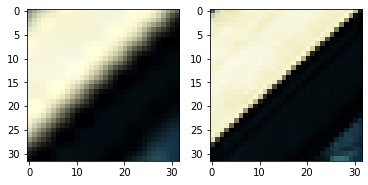

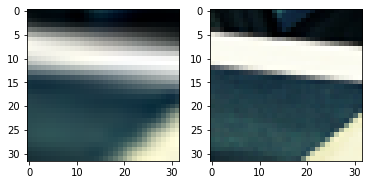

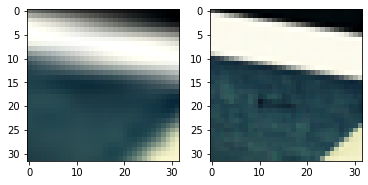

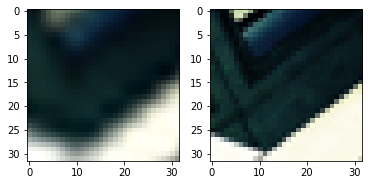

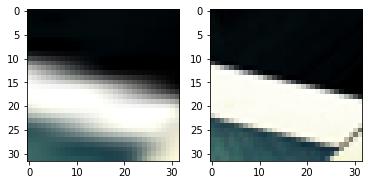

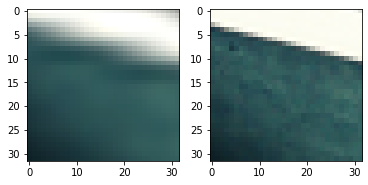

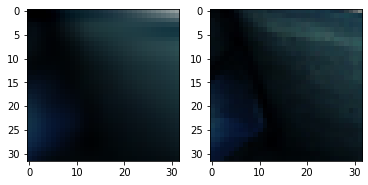

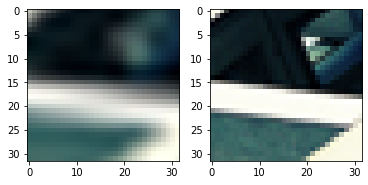

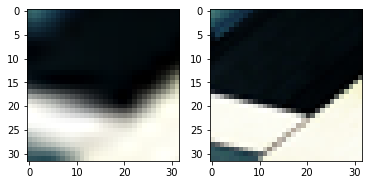

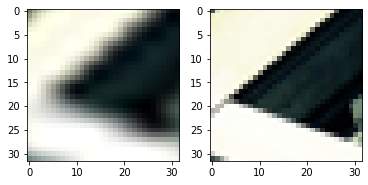

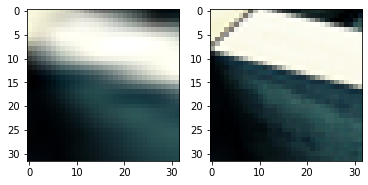

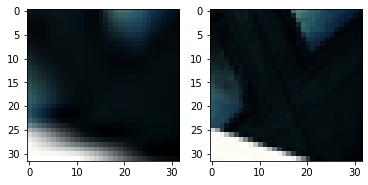

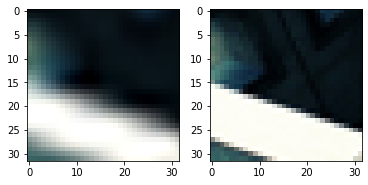

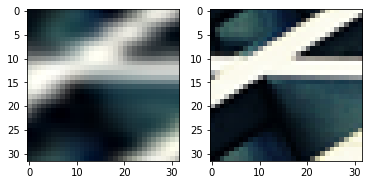

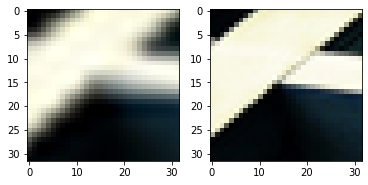

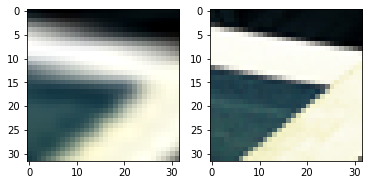

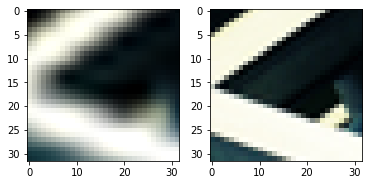

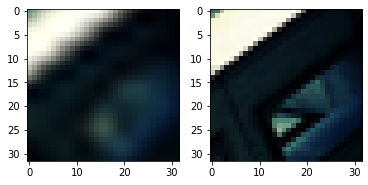

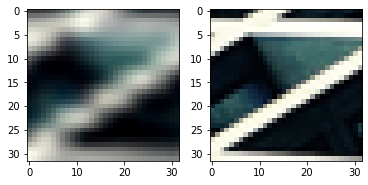

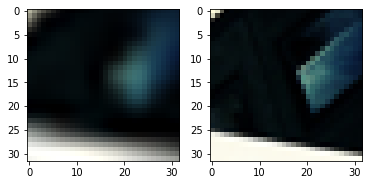

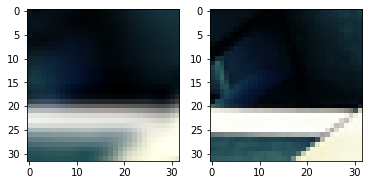

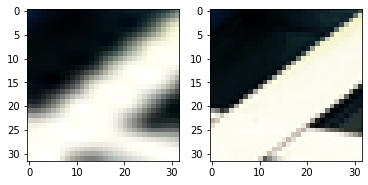

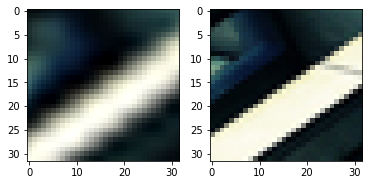

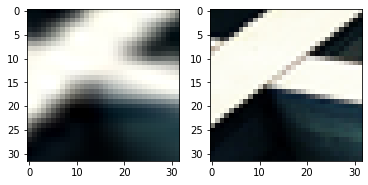

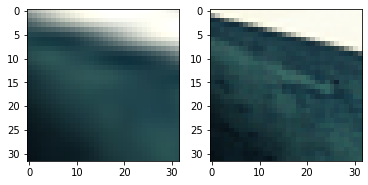

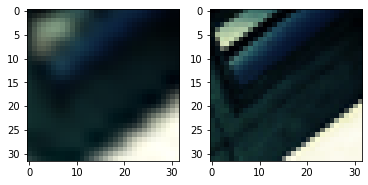

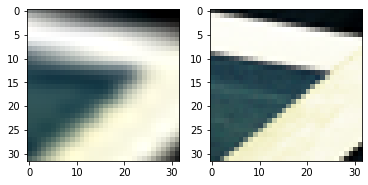

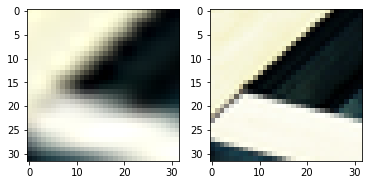

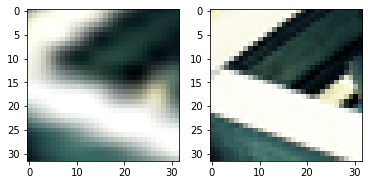

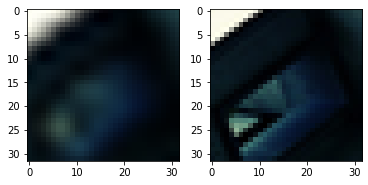

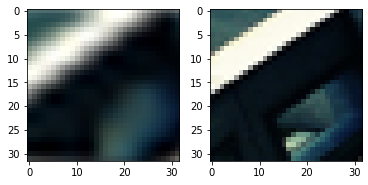

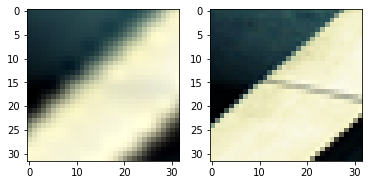

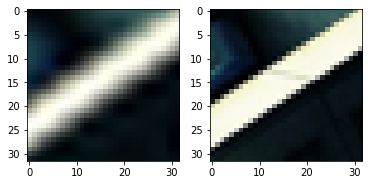

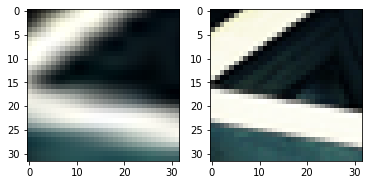

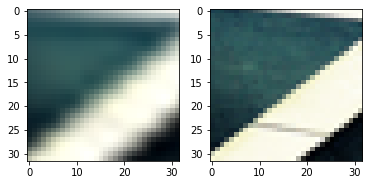

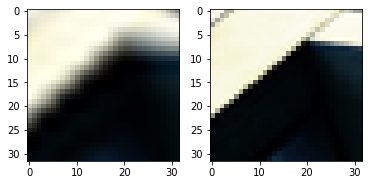

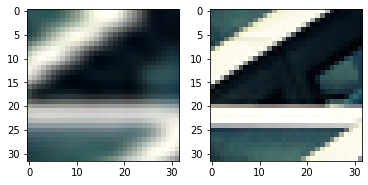

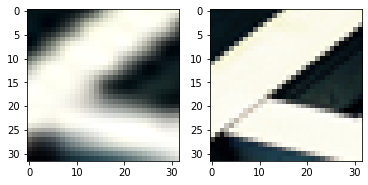

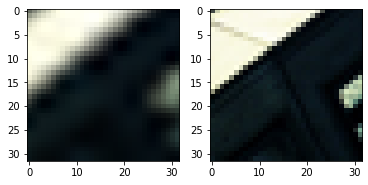

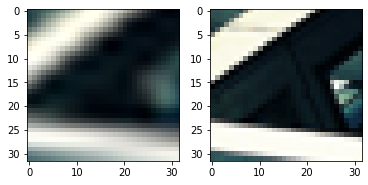

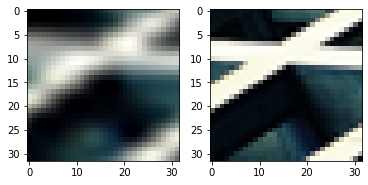

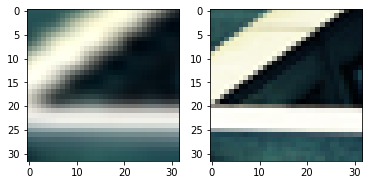

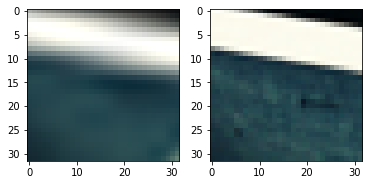

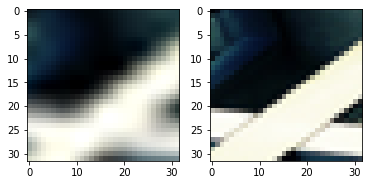

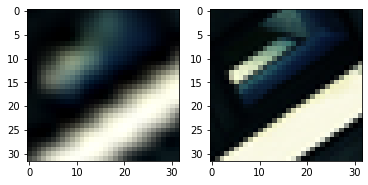

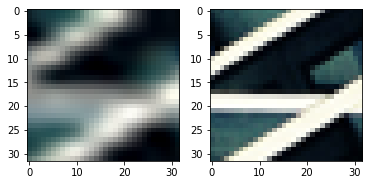

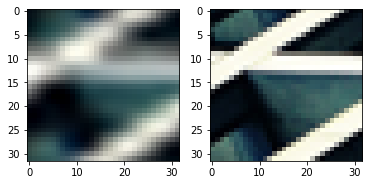

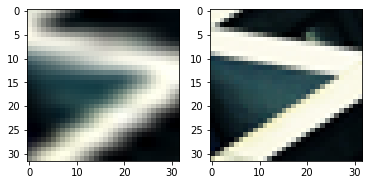

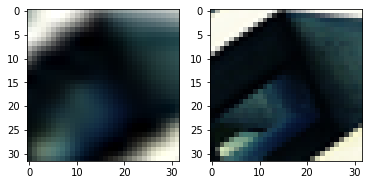

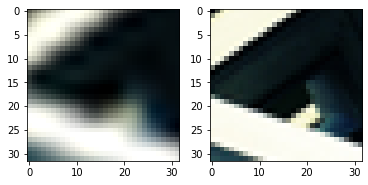

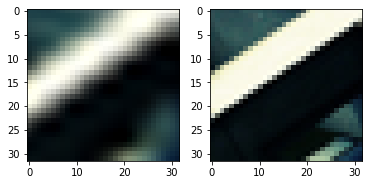

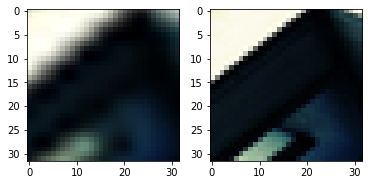

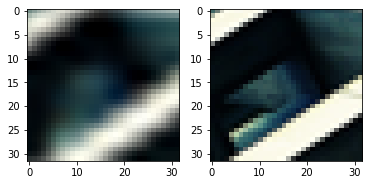

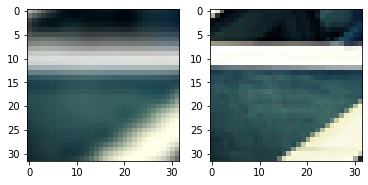

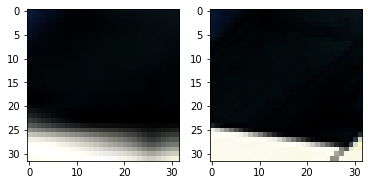

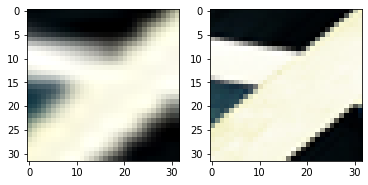

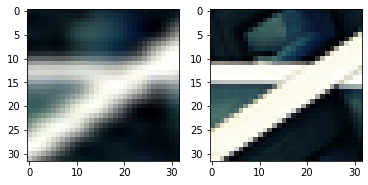

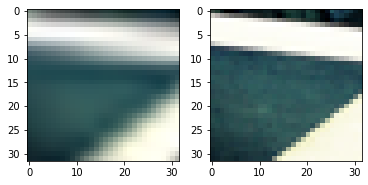

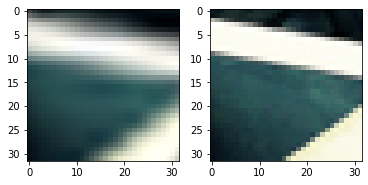

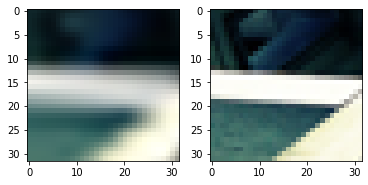

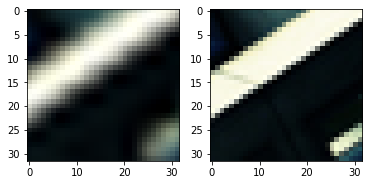

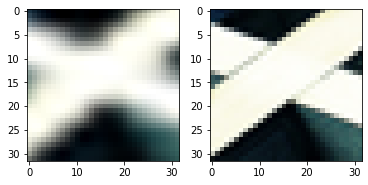

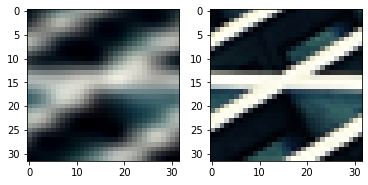

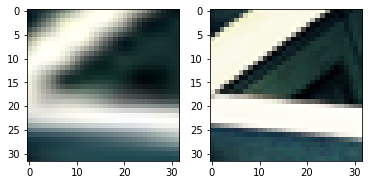

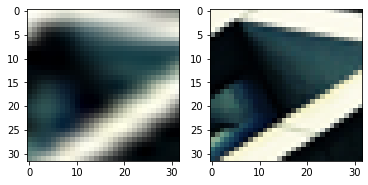

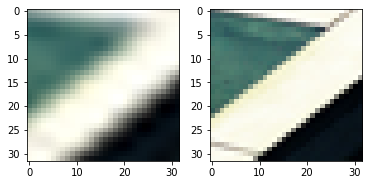

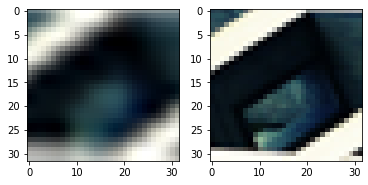

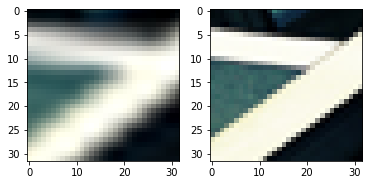

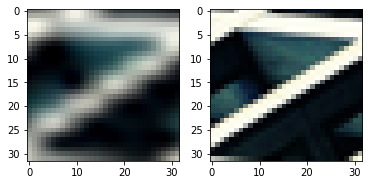

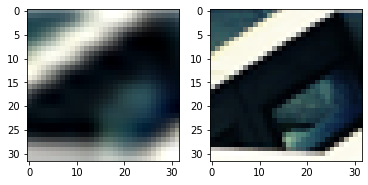

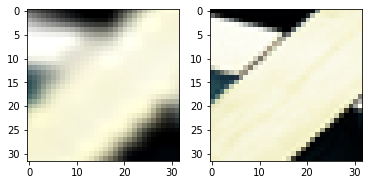

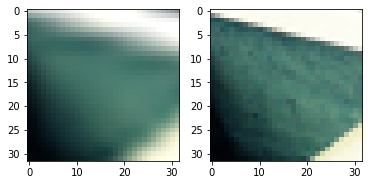

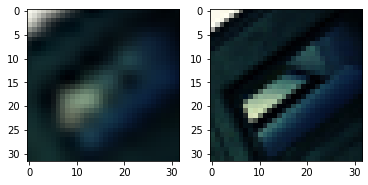

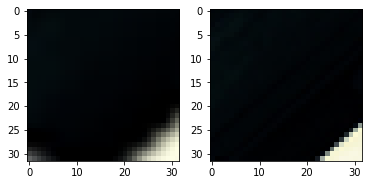

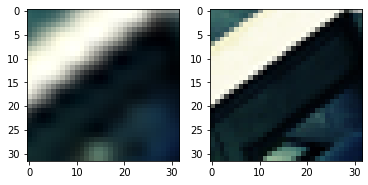

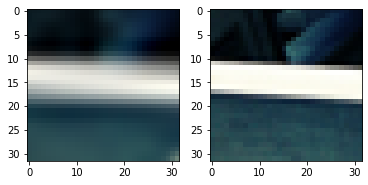

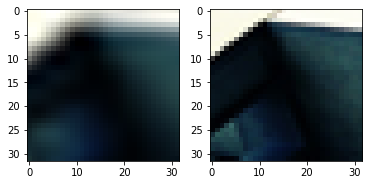

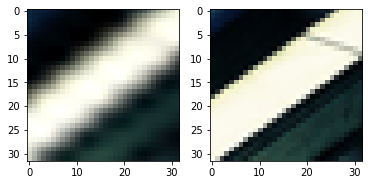

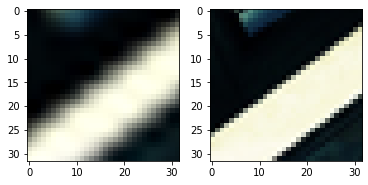

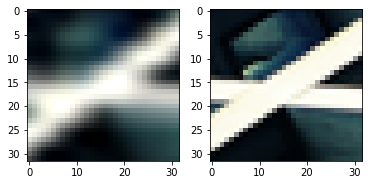

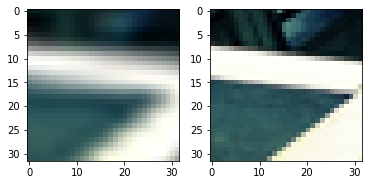

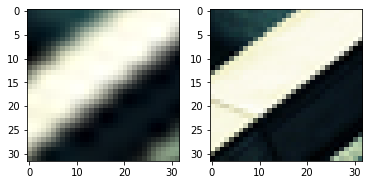

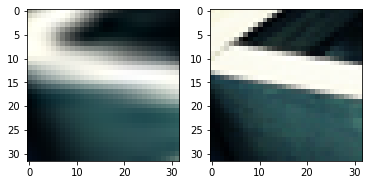

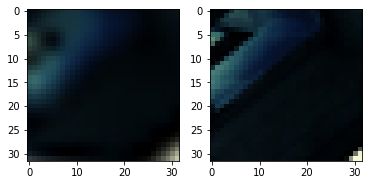

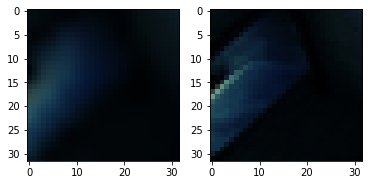

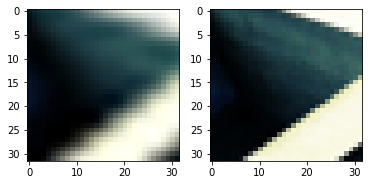

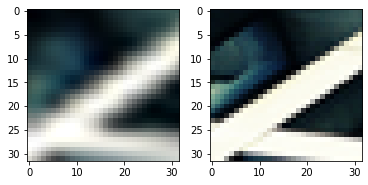

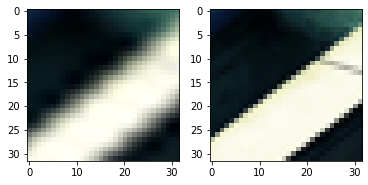

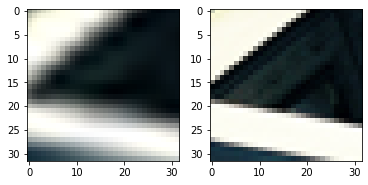

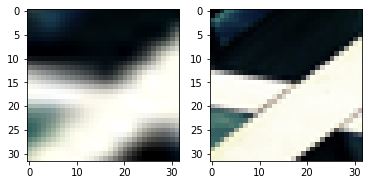

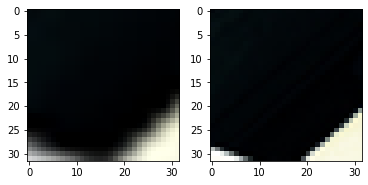

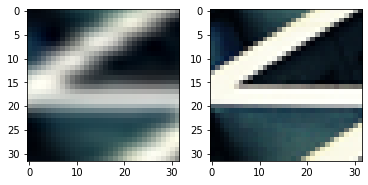

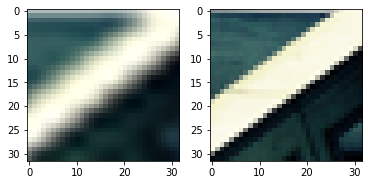

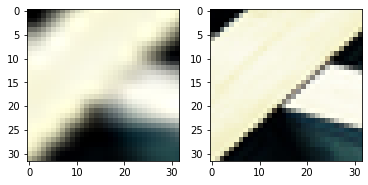

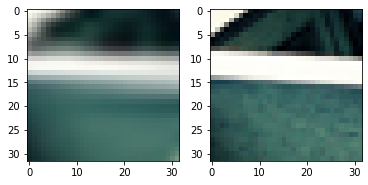

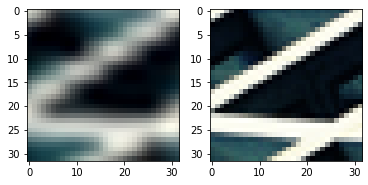

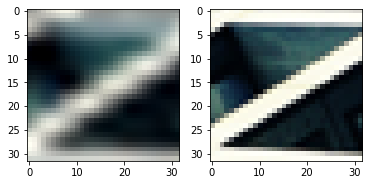

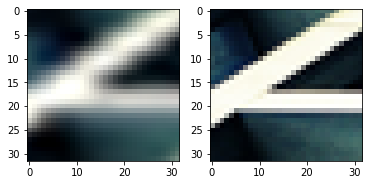

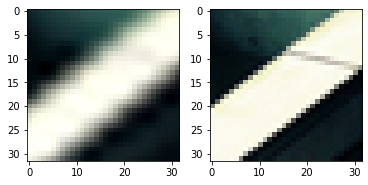

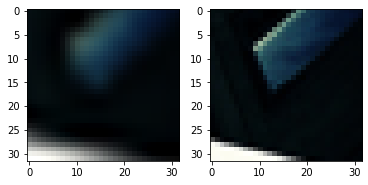

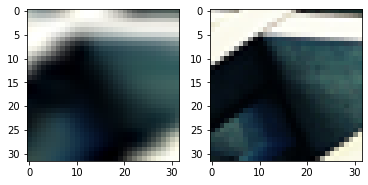

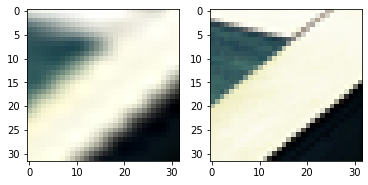

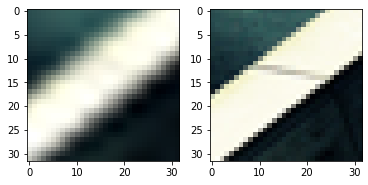

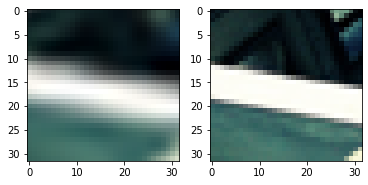

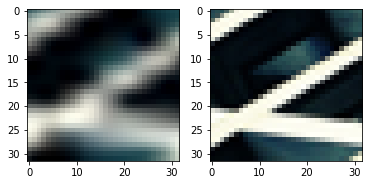

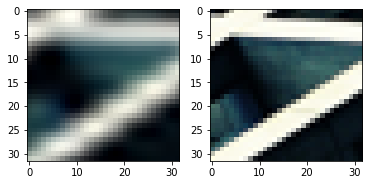

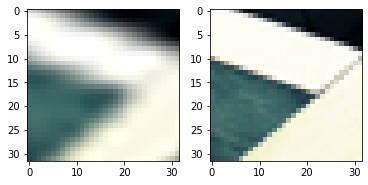

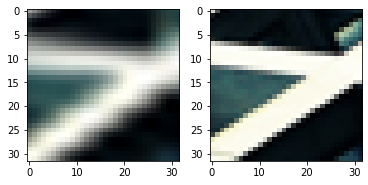

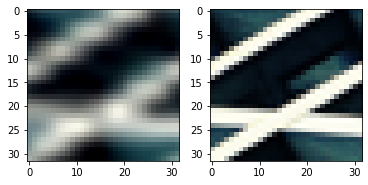

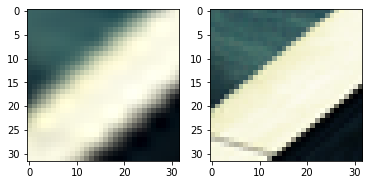

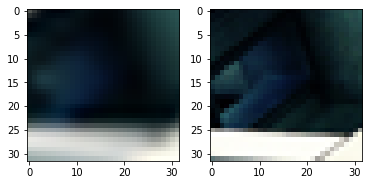

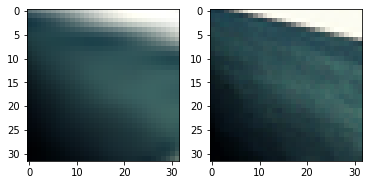

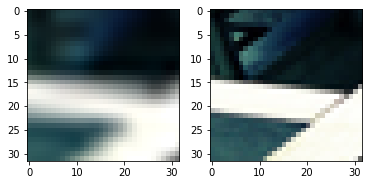

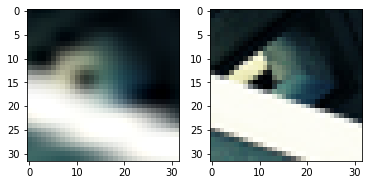

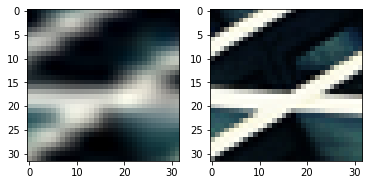

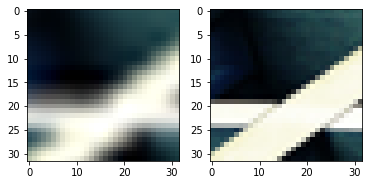

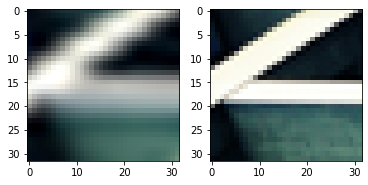

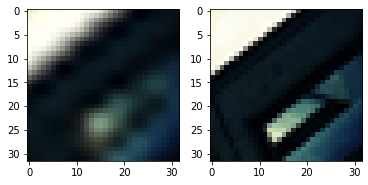

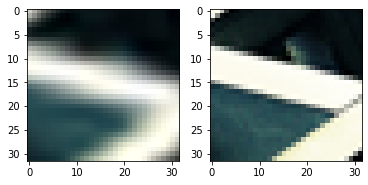

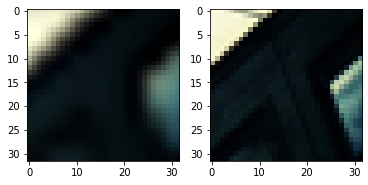

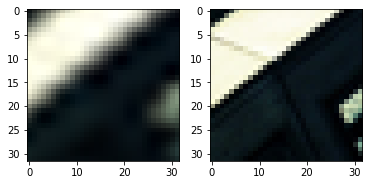

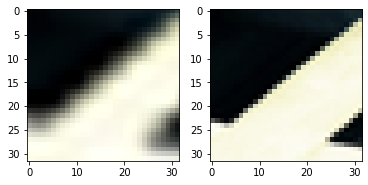

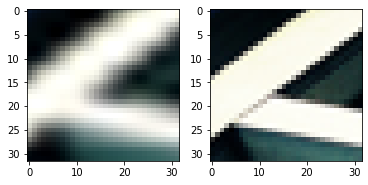

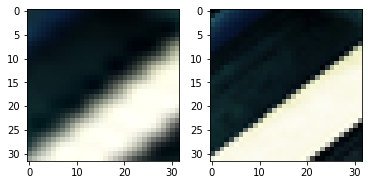

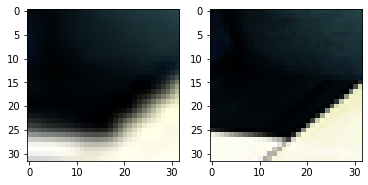

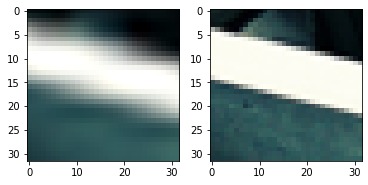

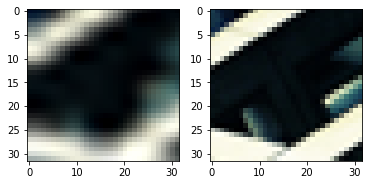

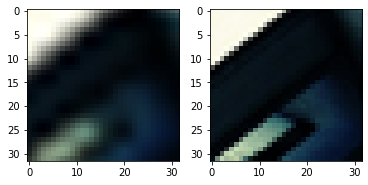

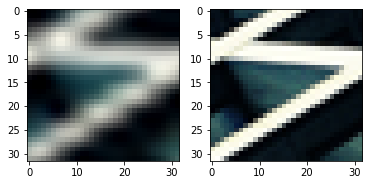

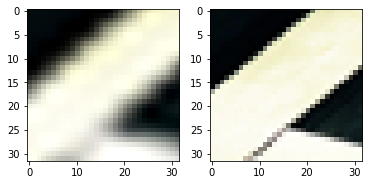

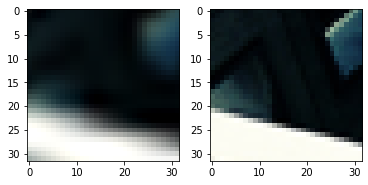

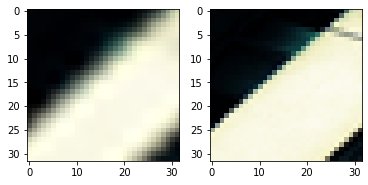

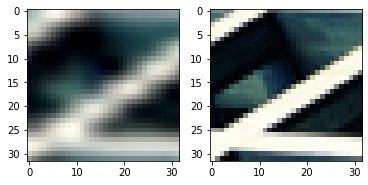

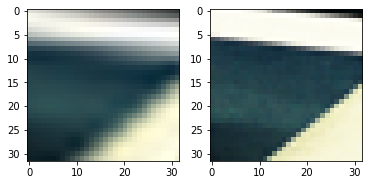

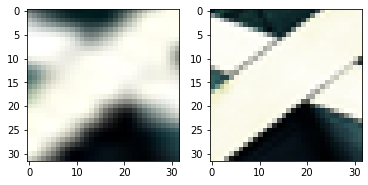

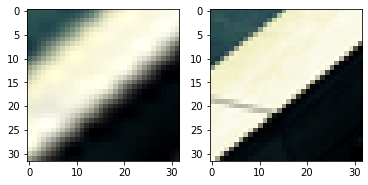

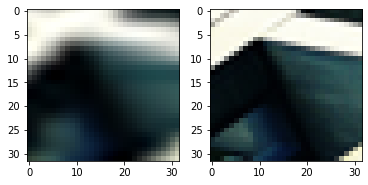

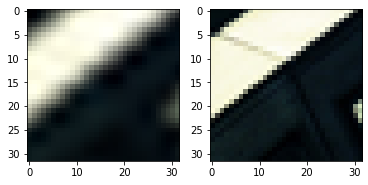

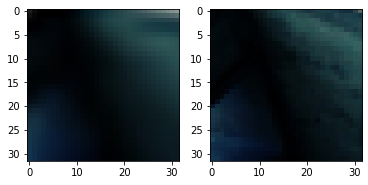

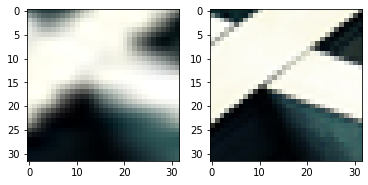

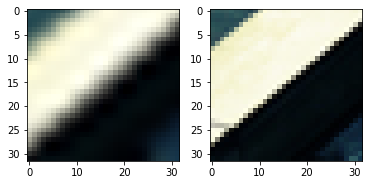

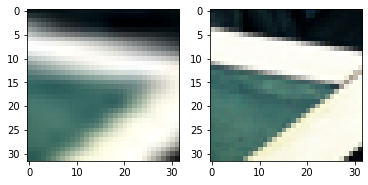

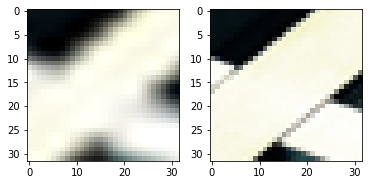

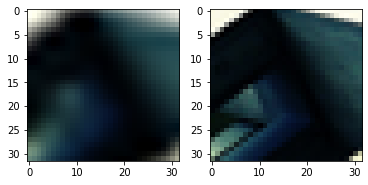

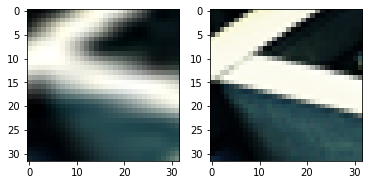

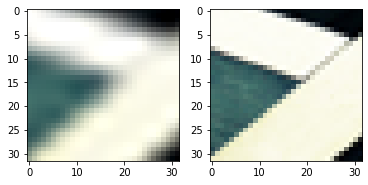

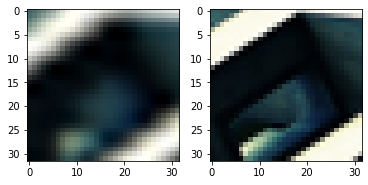

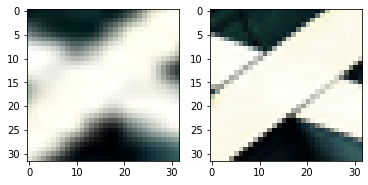

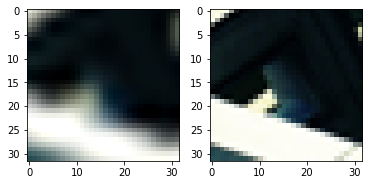

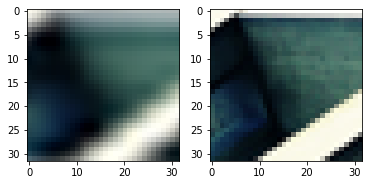

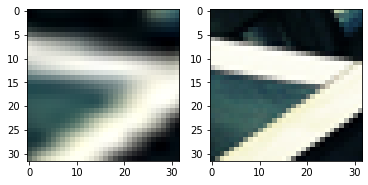

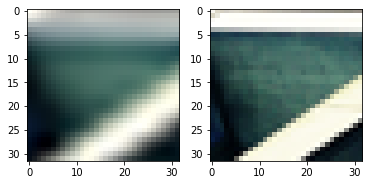

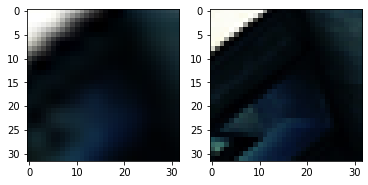

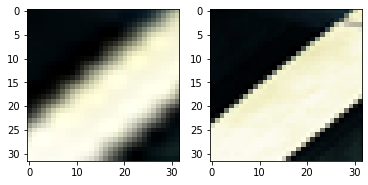

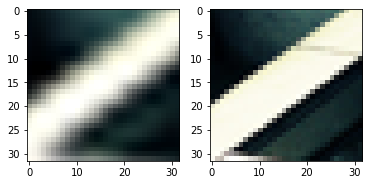

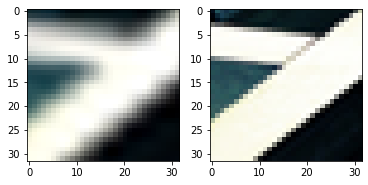

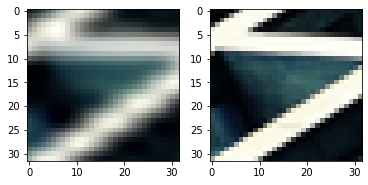

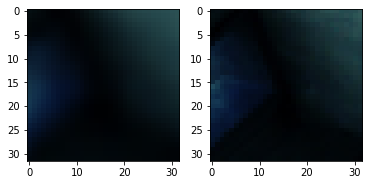

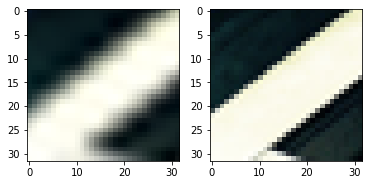

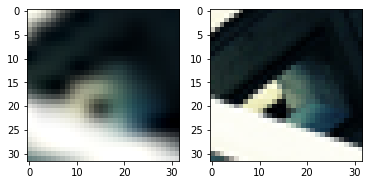

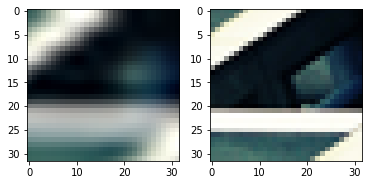

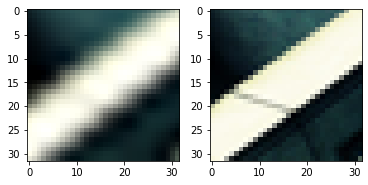

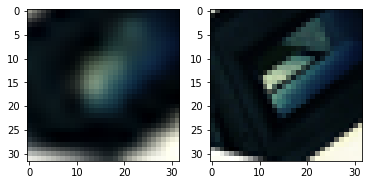

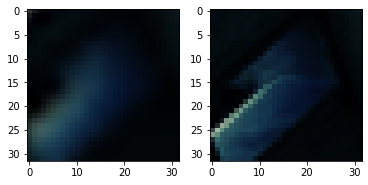

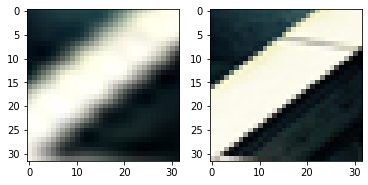

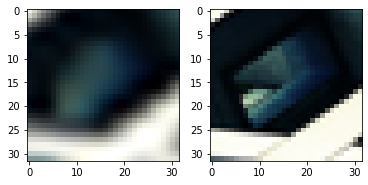

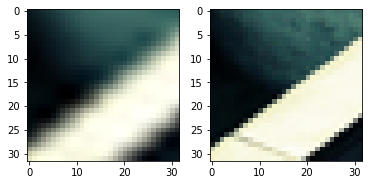

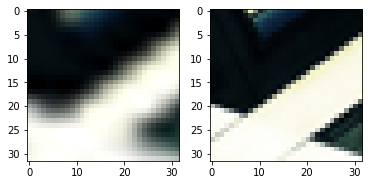

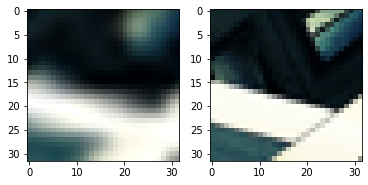

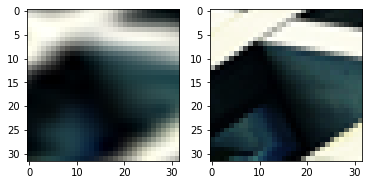

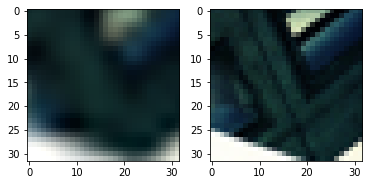

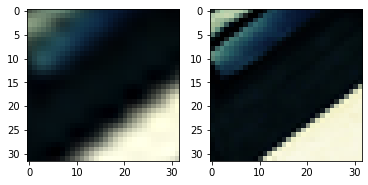

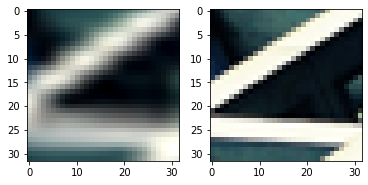

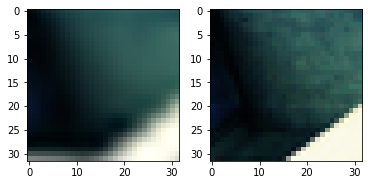

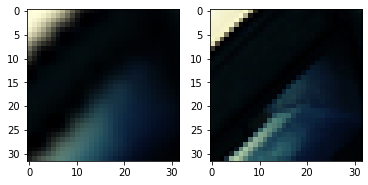

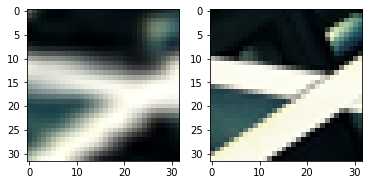

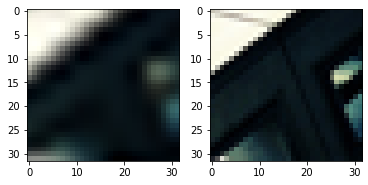

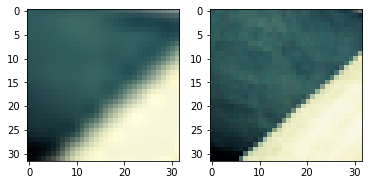

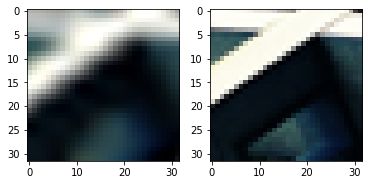

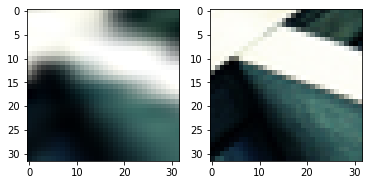

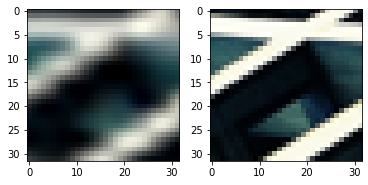

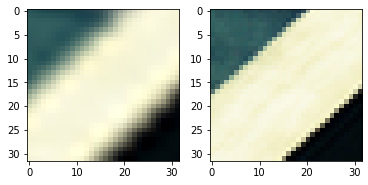

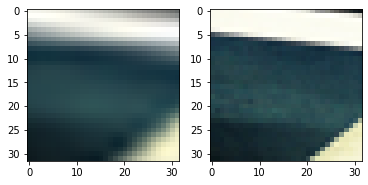

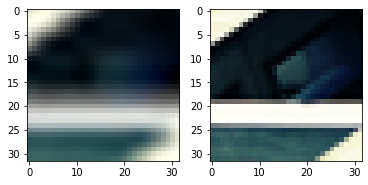

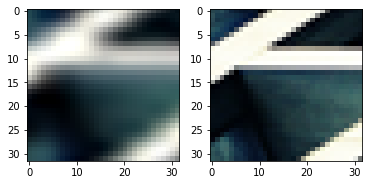

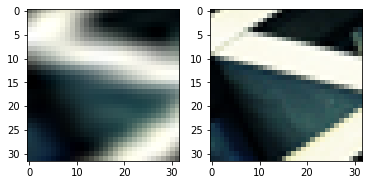

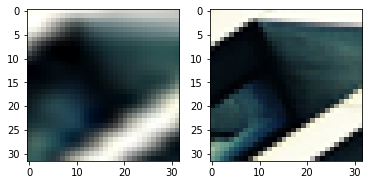

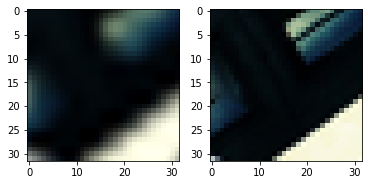

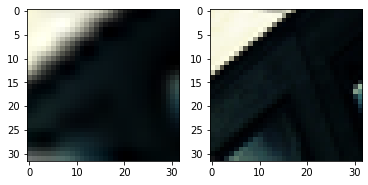

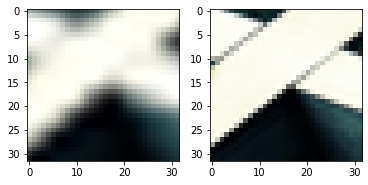

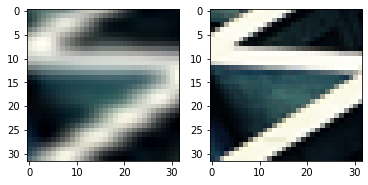

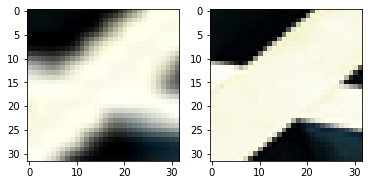

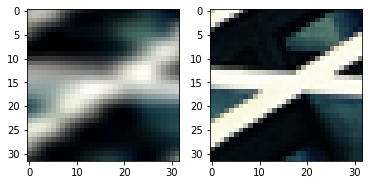

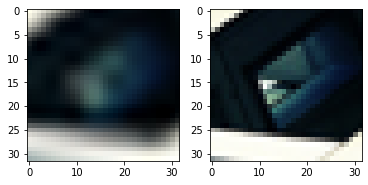

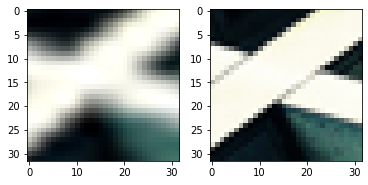

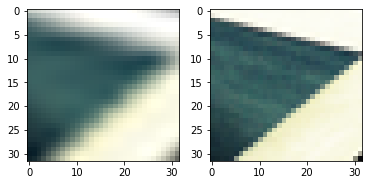

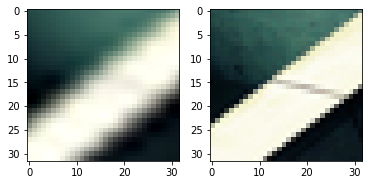

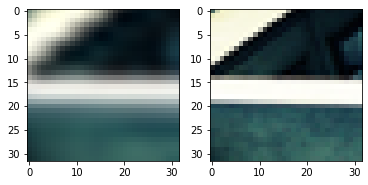

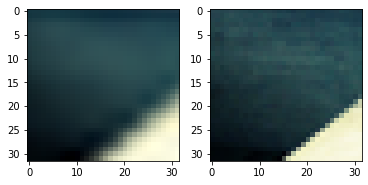

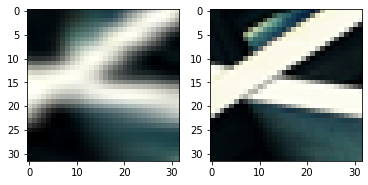

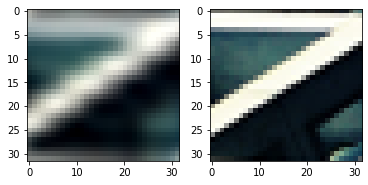

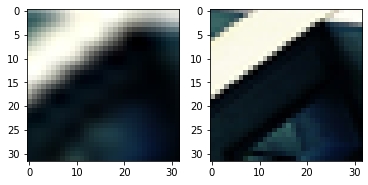

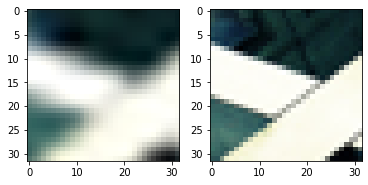

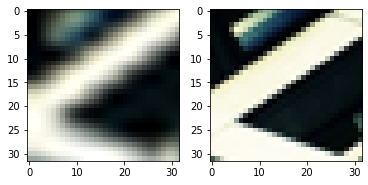

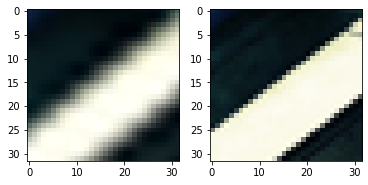

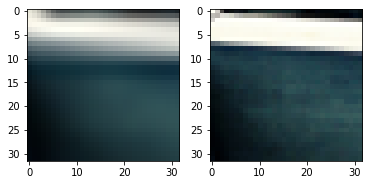

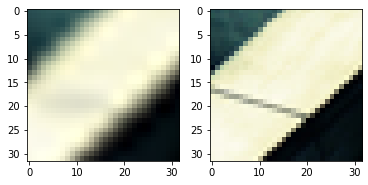

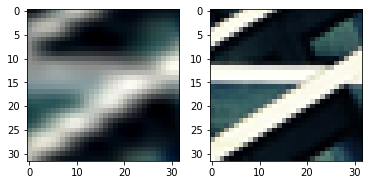

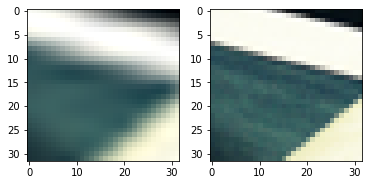

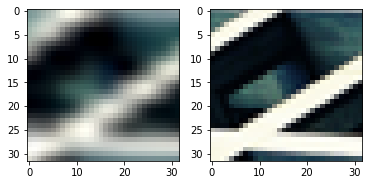

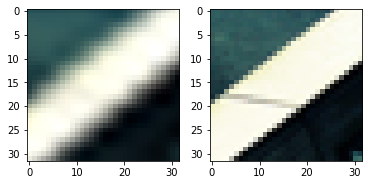

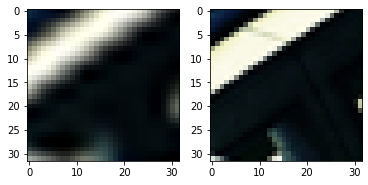

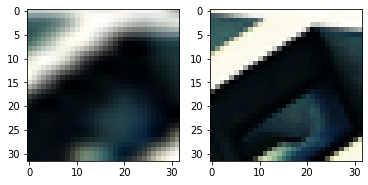

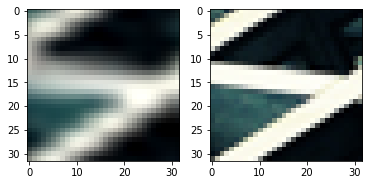

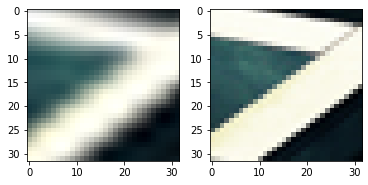

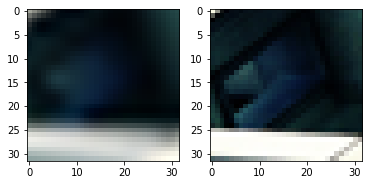

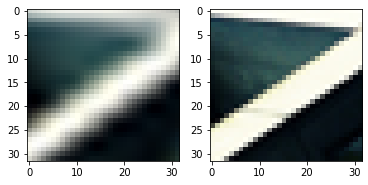

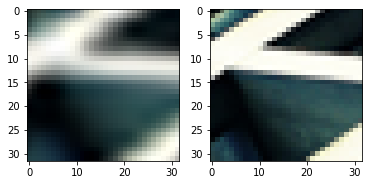

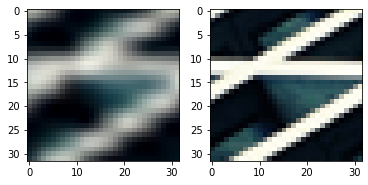

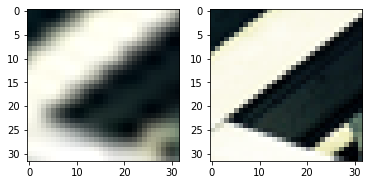

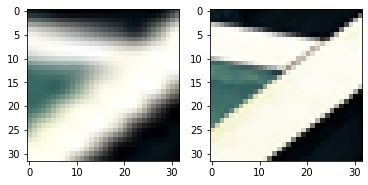

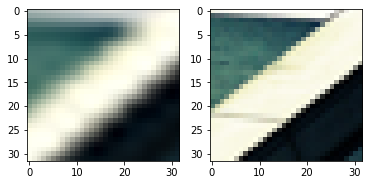

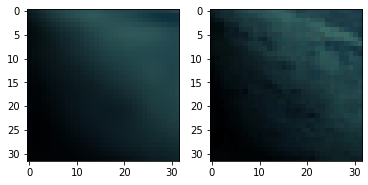

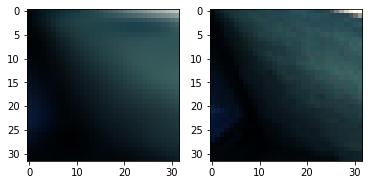

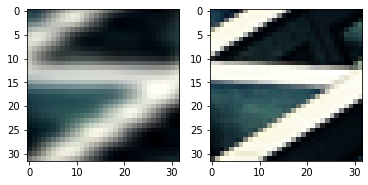

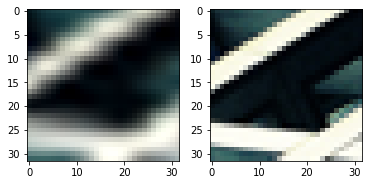

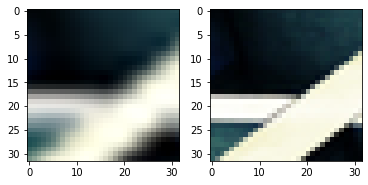

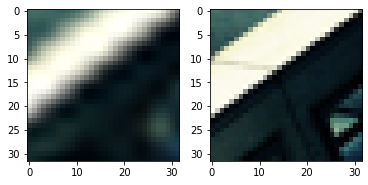

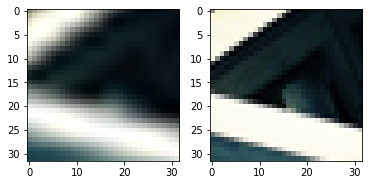

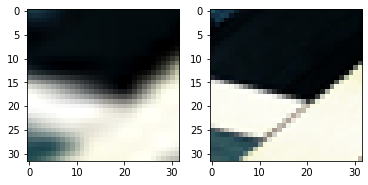

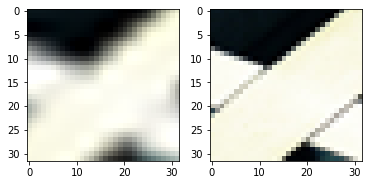

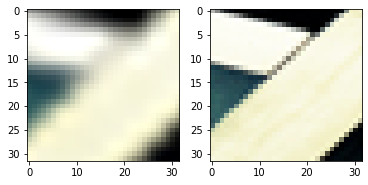

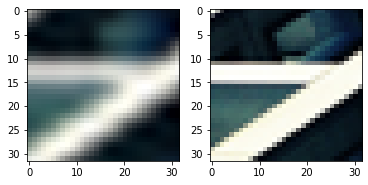

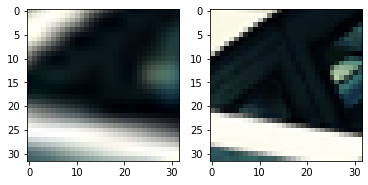

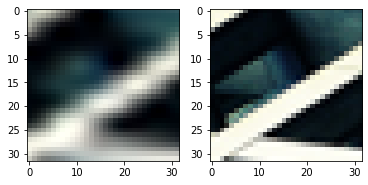

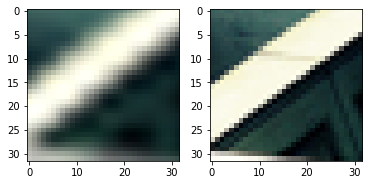

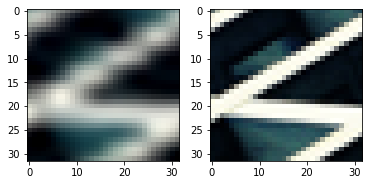

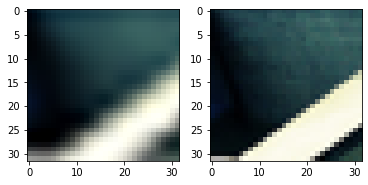

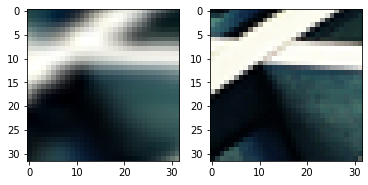

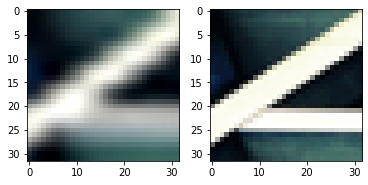

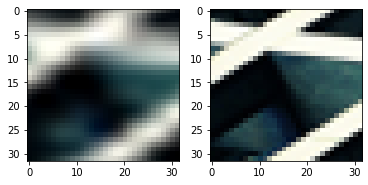

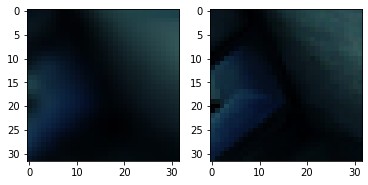

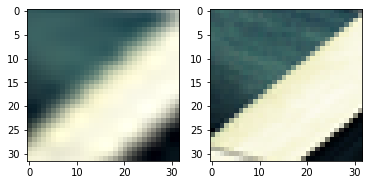

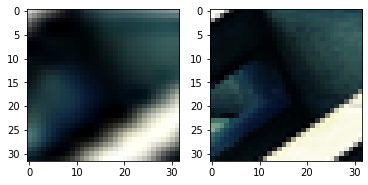

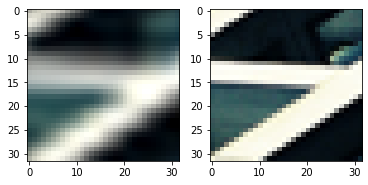

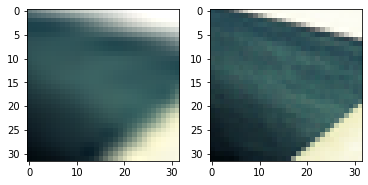

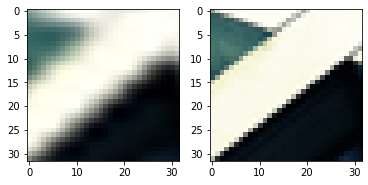

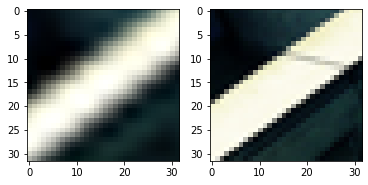

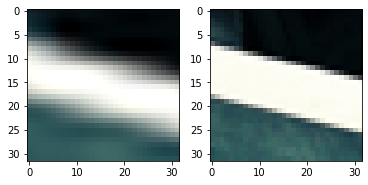

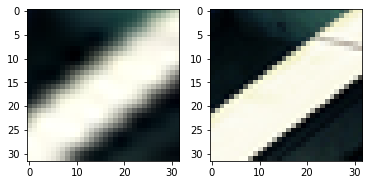

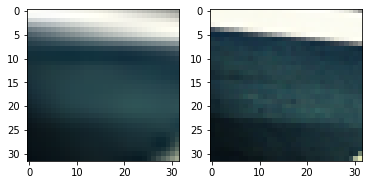

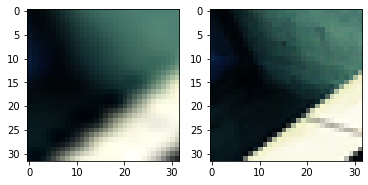

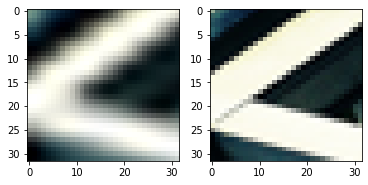

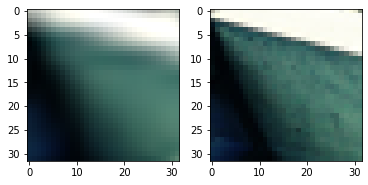

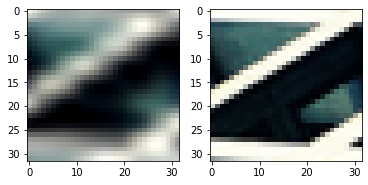

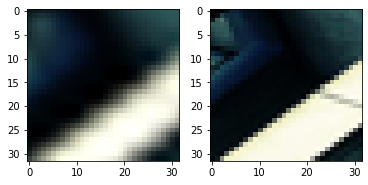

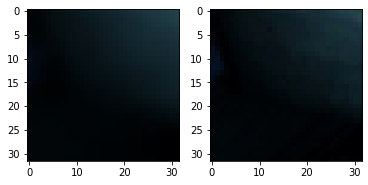

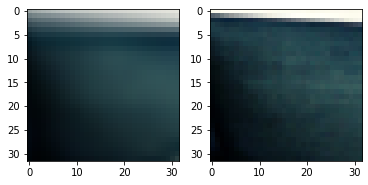

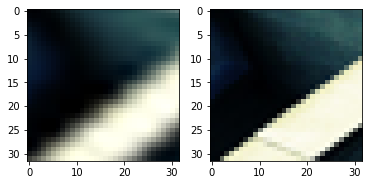

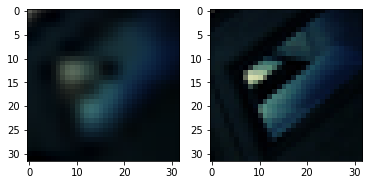

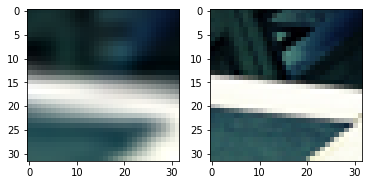

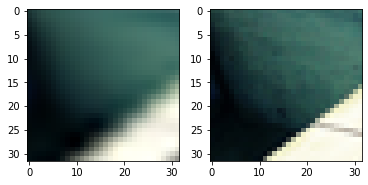

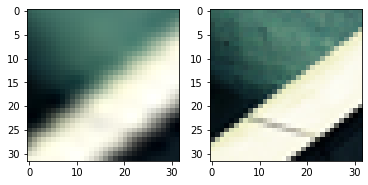

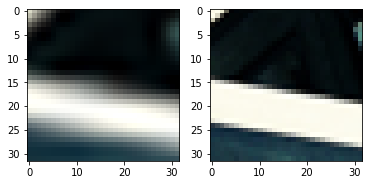

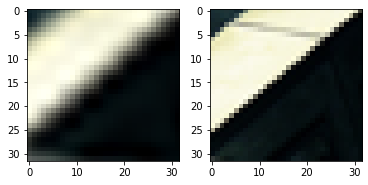

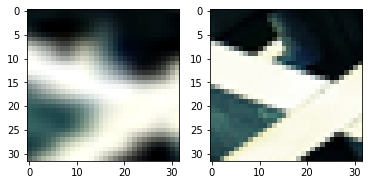

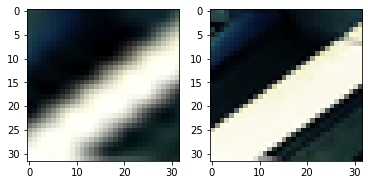

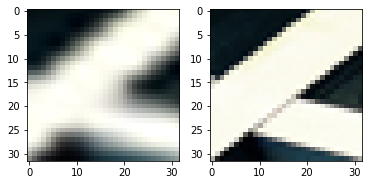

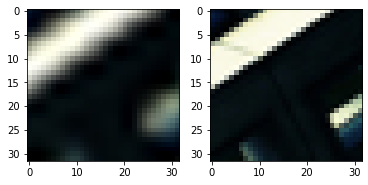

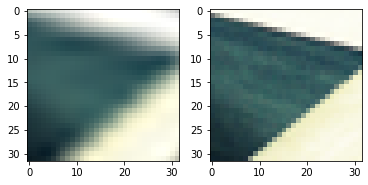

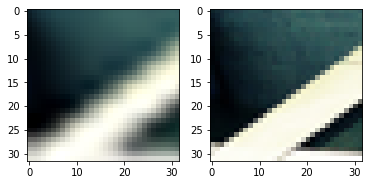

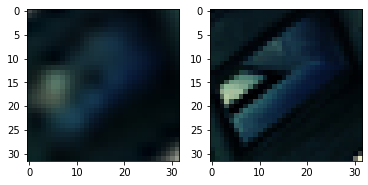

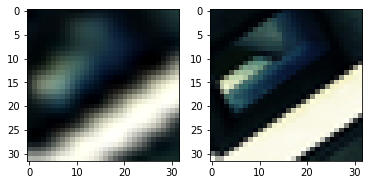

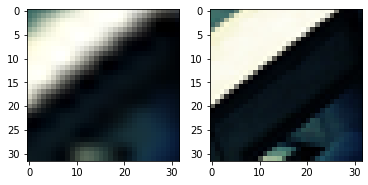

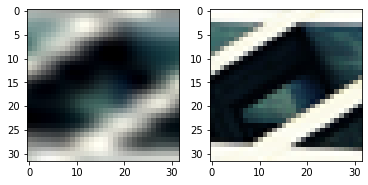

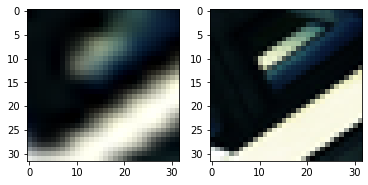

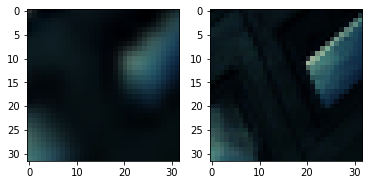

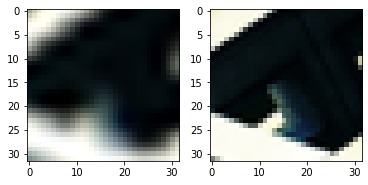

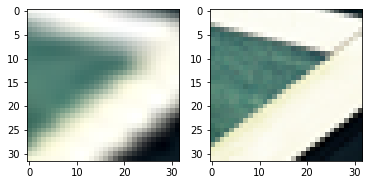

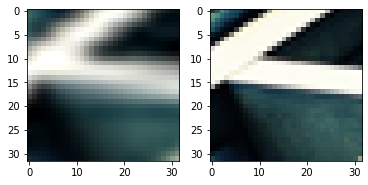

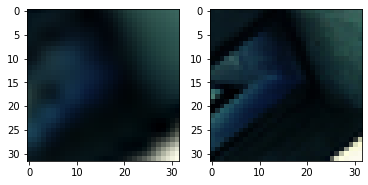

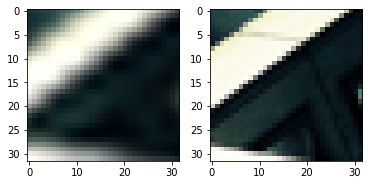

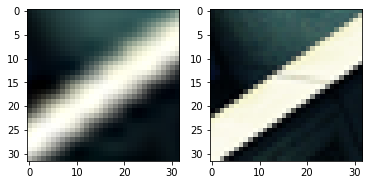

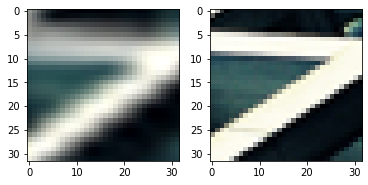

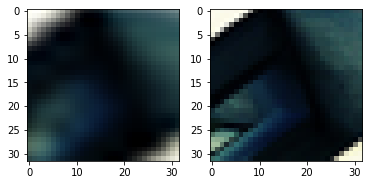

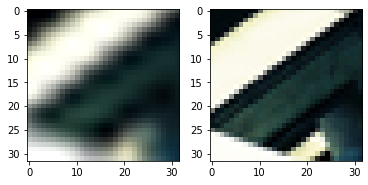

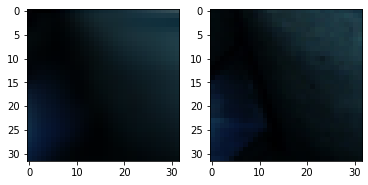

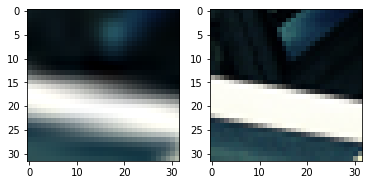

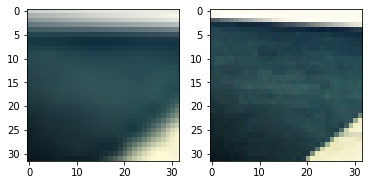

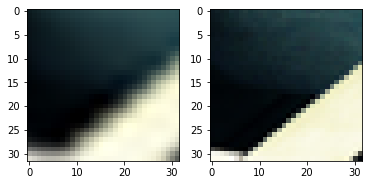

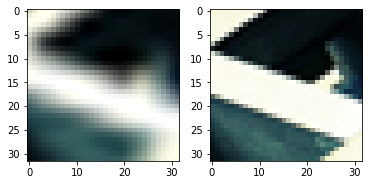

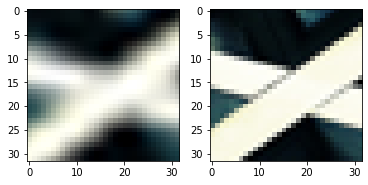

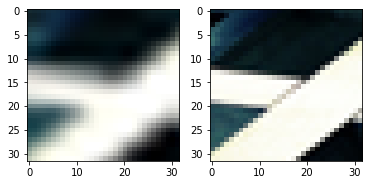

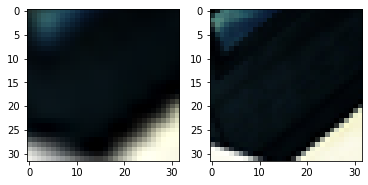

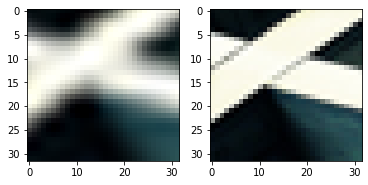

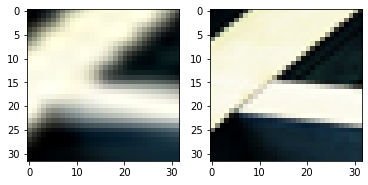

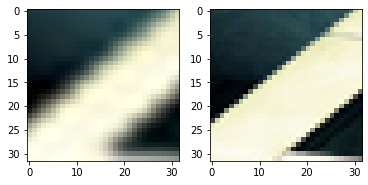

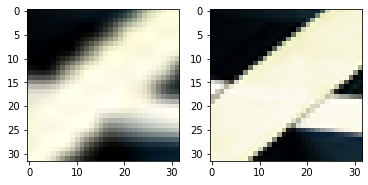

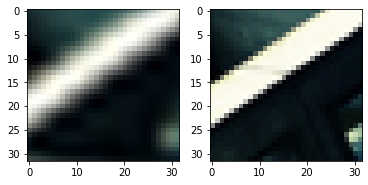

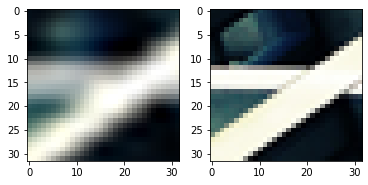

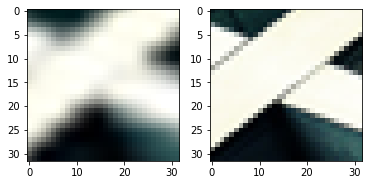

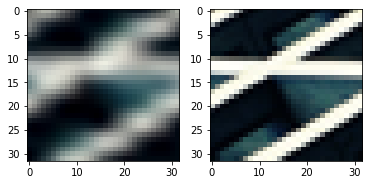

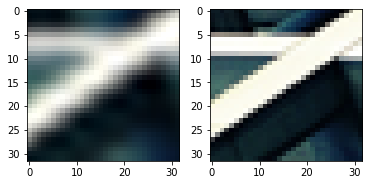

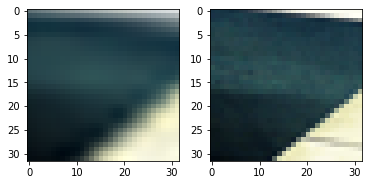

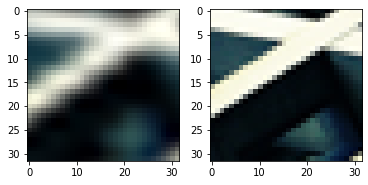

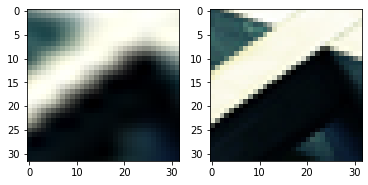

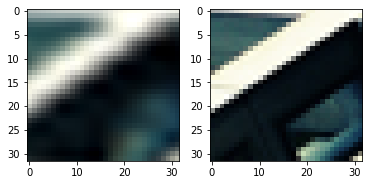

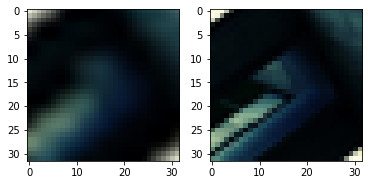

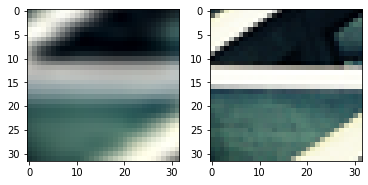

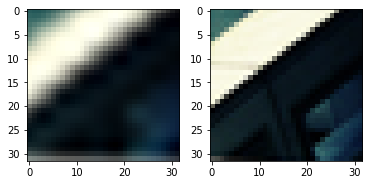

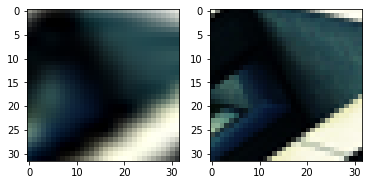

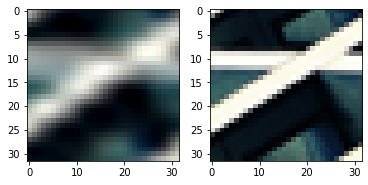

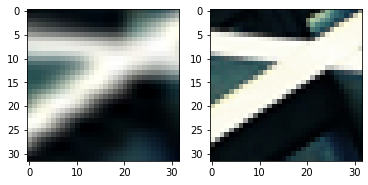

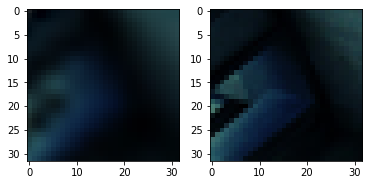

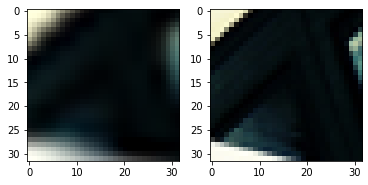

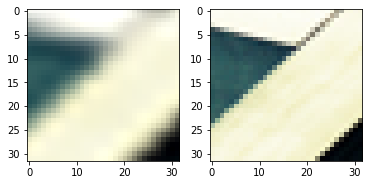

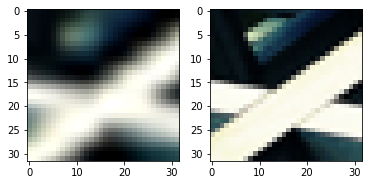

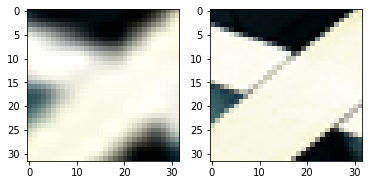

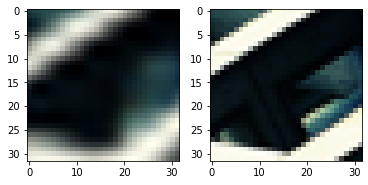

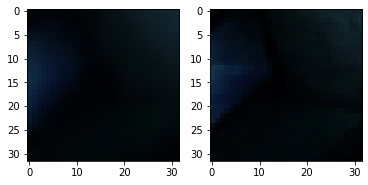

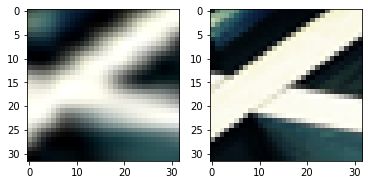

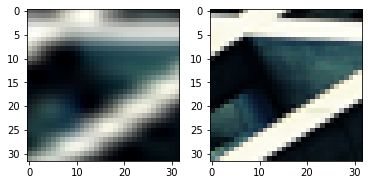

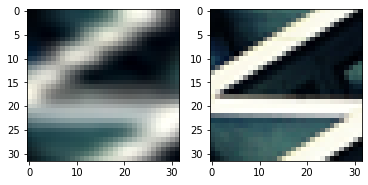

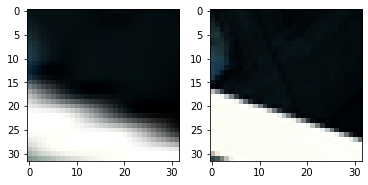

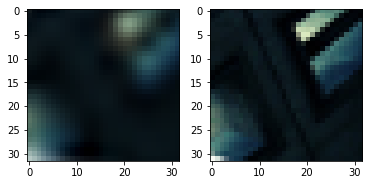

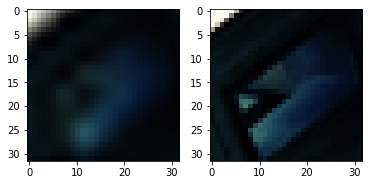

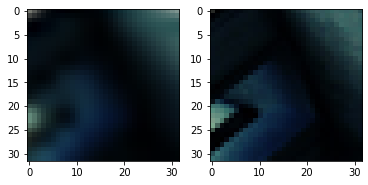

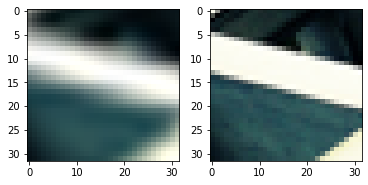

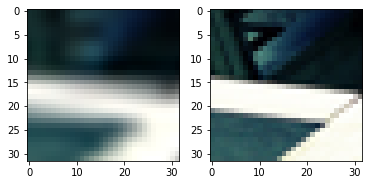

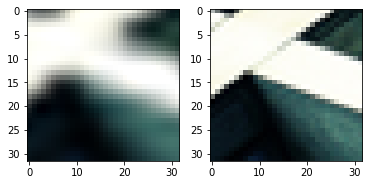

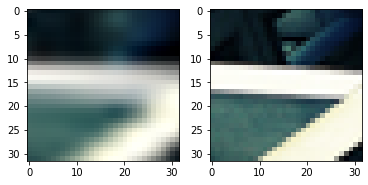

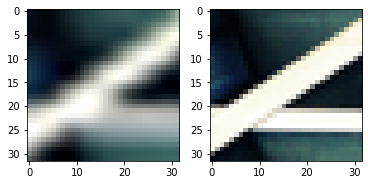

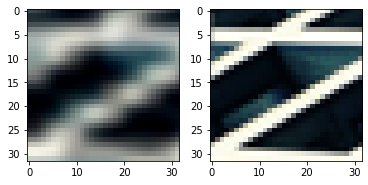

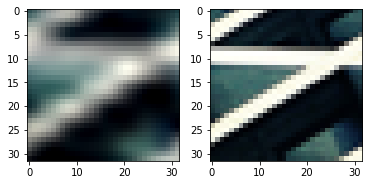

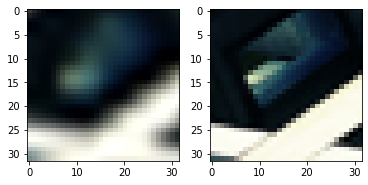

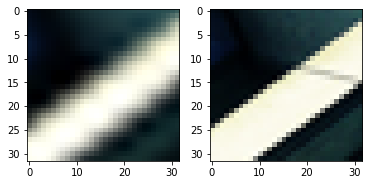

KeyboardInterrupt: 

In [13]:
def imshow(img1, img2):
#     img = img / 2 + 0.5     # unnormalize
    npimg1 = img1.numpy()
    npimg2 = img2.numpy()
    plt.subplot(1,2,1)
    plt.imshow(np.transpose(npimg1, (1, 2, 0)))
    plt.subplot(1,2,2)
    plt.imshow(np.transpose(npimg2, (1, 2, 0)))
    plt.show()
    
for idx, data in enumerate(train_dataloader):
    image, label = data
#     if idx == 1 :
    imshow(image[0], label[0])

## Define Model

필요한 라이브러리를 import 해줍니다.

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch


모델 구조를 짜기 편하게 하도록 conv2d 함수를 따로 정의해줍니다.

In [15]:
def conv2d(in_channel, out_channel, kernel=3,  strides=1,  activation=None):
    m = []
    pad = nn.ZeroPad2d(1)
    m.append(pad)

    conv = nn.Conv2d(in_channel, out_channel,kernel,strides)
    m.append(conv)
    nn.init.kaiming_normal_(conv.weight)
    nn.init.zeros_(conv.bias)
    if activation==None:
        pass
    elif activation.lower()=='relu':
        m.append(nn.ReLU(True))
    
    return nn.Sequential(*m)

모델 구조를 정의해줍니다.

In [16]:
class ZSSR(nn.Module):
    def __init__(self):
        super(ZSSR, self).__init__()
        self.head = conv2d(3,64, activation='relu')
        m = [ conv2d(64,64, activation='relu')
            for _ in range(2,8)
        ] 
        
        self.body = nn.Sequential(*m)
        self.tail = conv2d(64,3)
        
        
    def forward(self, x):
        self.input = x
        y = self.head(self.input)
        y = self.body(y)
        y = self.tail(y)
        self.output = self.input + y
        return self.output


모델의 instance 를 만들어줍니다.

In [17]:
net = ZSSR()
net = net.to('cuda')
print(net)

ZSSR(
  (head): Sequential(
    (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
  )
  (body): Sequential(
    (0): Sequential(
      (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      (1): Conv2d(64, 64, kernel_size=(3, 3),

## Train Model

필요한 라이브러리를 import 해줍니다.

In [18]:

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms


수업시간에 배우 train class 에서 loss를 지정하는 criterion 부분을 수정해서 다시 정의합니다.

In [19]:
class Train(object):
    def __init__(self, dataloader, model):
        self.dataloader = dataloader
        self.model = model
        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
            
    def __call__(self):
        for epoch in range(50):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(self.dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
            print(f'[EP {epoch + 1}] loss: {running_loss/len(self.dataloader):.5f}')
            running_loss = 0.0

        print('Finished Training')

trainer 를 정의하고 학습을 진행해줍니다

In [20]:
tr = Train(train_dataloader, net)
tr()

[EP 1] loss: 0.01424
[EP 2] loss: 0.00963
[EP 3] loss: 0.00873
[EP 4] loss: 0.00810
[EP 5] loss: 0.00762
[EP 6] loss: 0.00724
[EP 7] loss: 0.00691
[EP 8] loss: 0.00663
[EP 9] loss: 0.00638
[EP 10] loss: 0.00616
[EP 11] loss: 0.00597
[EP 12] loss: 0.00579
[EP 13] loss: 0.00563
[EP 14] loss: 0.00548
[EP 15] loss: 0.00534
[EP 16] loss: 0.00521
[EP 17] loss: 0.00508
[EP 18] loss: 0.00496
[EP 19] loss: 0.00484
[EP 20] loss: 0.00473
[EP 21] loss: 0.00463
[EP 22] loss: 0.00453
[EP 23] loss: 0.00444
[EP 24] loss: 0.00435
[EP 25] loss: 0.00427
[EP 26] loss: 0.00420
[EP 27] loss: 0.00413
[EP 28] loss: 0.00406
[EP 29] loss: 0.00400
[EP 30] loss: 0.00394
[EP 31] loss: 0.00389
[EP 32] loss: 0.00383
[EP 33] loss: 0.00378
[EP 34] loss: 0.00374
[EP 35] loss: 0.00369
[EP 36] loss: 0.00365
[EP 37] loss: 0.00361
[EP 38] loss: 0.00357
[EP 39] loss: 0.00353
[EP 40] loss: 0.00349
[EP 41] loss: 0.00346
[EP 42] loss: 0.00342
[EP 43] loss: 0.00339
[EP 44] loss: 0.00336
[EP 45] loss: 0.00333
[EP 46] loss: 0.003

## Test Model

이제 학습된 모델에 다시 test image를 넣어서 모델의 성능을 확인해보겠습니다

In [21]:
import numpy as np
import torch
import cv2

우선 test image 를 불러와 bicubic upsampling 을 시켜줍니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


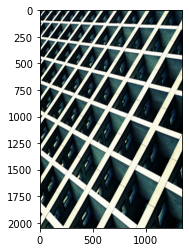

In [22]:
test_image_path = 'input/butterfly.png'
test_image = cv2.imread(test_image_path).astype(np.float32)
test_image = cv2.resize(test_image, (scale*test_image.shape[0], scale*test_image.shape[1]), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(test_image/255., cv2.COLOR_BGR2RGB))
plt.show()

그리고 model에 넣어주기 위해서 0~1 사이로 normalize를 해준 이후 tensor로 변환해서 gpu에 올려줍니다

In [23]:
test_image_in = np.expand_dims(test_image, 0)/255.
test_image_in = torch.tensor(np.transpose(test_image_in, (0, 3, 1, 2)))
test_image_in = test_image_in.to('cuda')

학습된 모델에 test image를 넣어서 sr결과를 뽑아냅니다

In [24]:
sr_image = net(test_image_in)

sr 결과를 보기위해 cpu로 다시 가져오고 이미지 차원을 변경해주는 등의 전처리를 해주고 이미지를 확인합니다

In [25]:
sr_image = sr_image.cpu().detach().numpy()

In [26]:
sr_image = np.transpose(sr_image, (0,2,3,1))
sr_image = sr_image[0, :, :, :]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


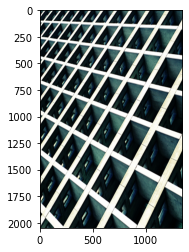

In [27]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB))
plt.show()

학습하기 이전의 입력 이미지보다 선명해진 것을 확인할 수 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


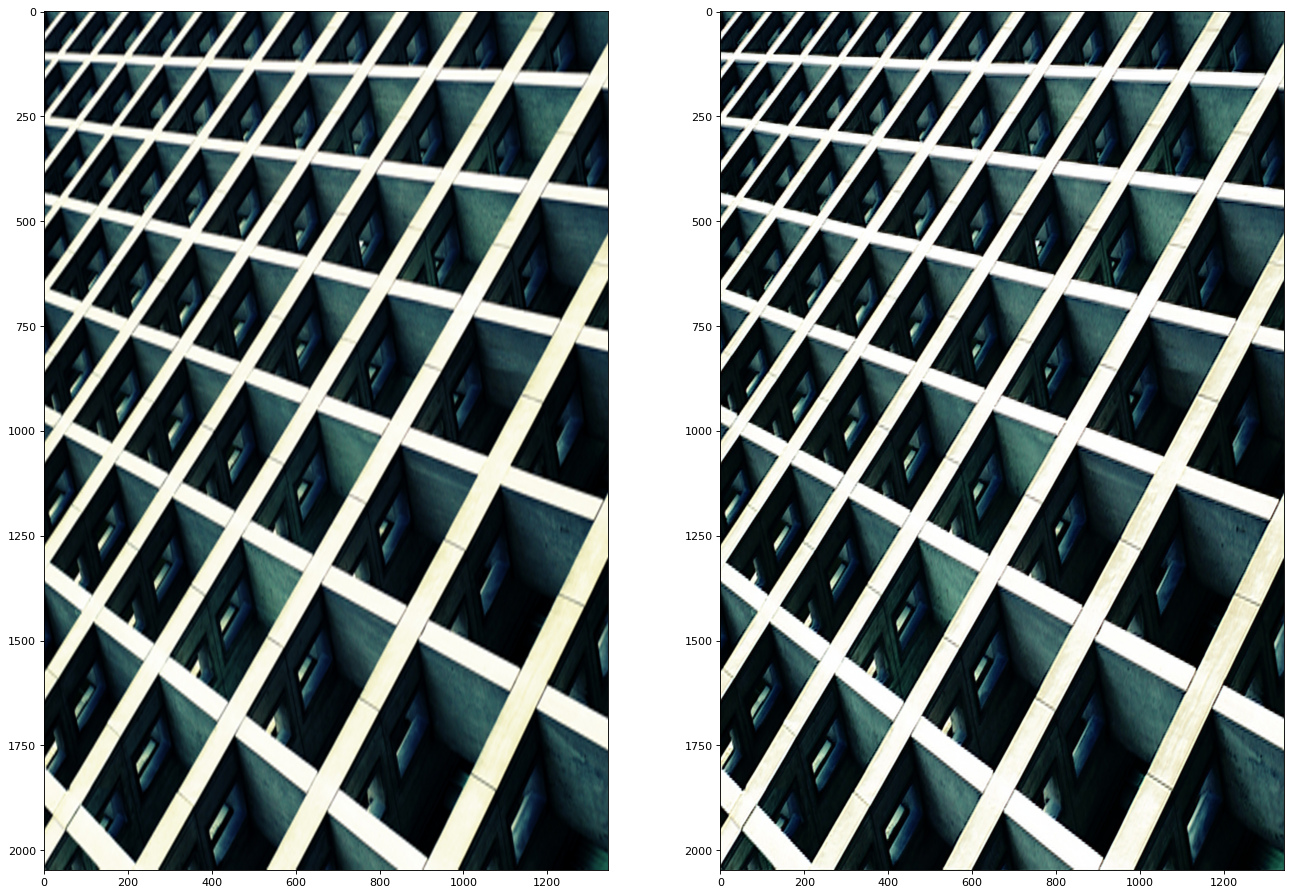

In [28]:
from matplotlib.pyplot import figure
figure(figsize=(20, 30), dpi=80)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(test_image/255., cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB))
plt.show()

확대해서 보면 성능을 확인하기 좋습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


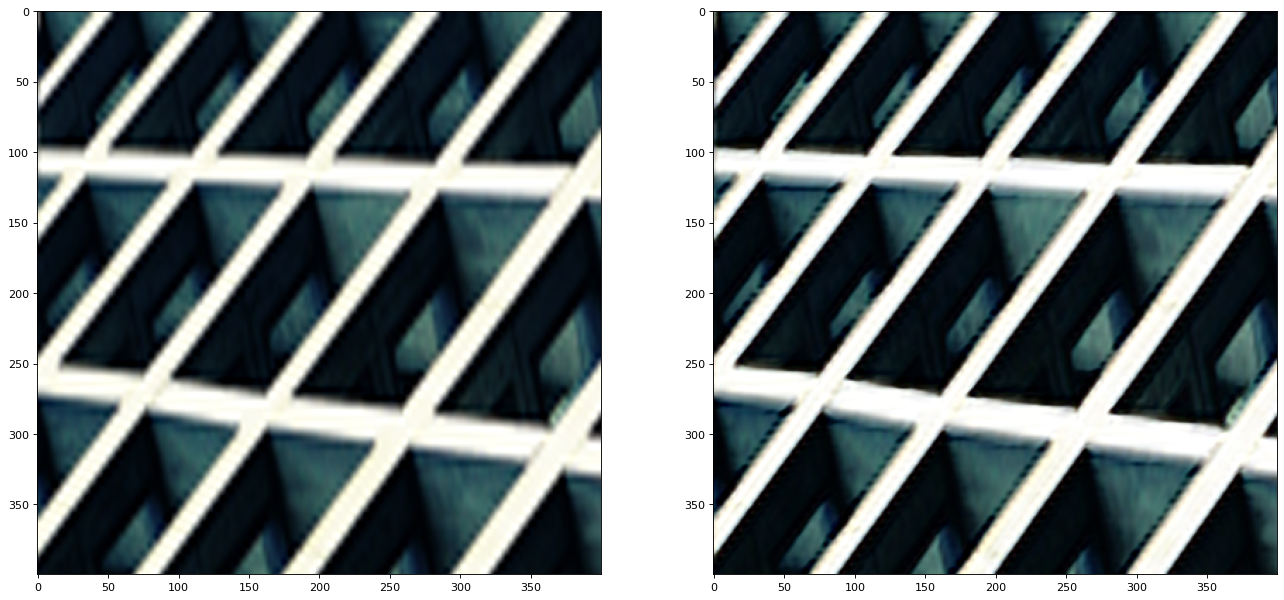

In [30]:
from matplotlib.pyplot import figure
figure(figsize=(20, 30), dpi=80)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(test_image[0:400, 0:400,:]/255., cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(sr_image[0:400, 0:400,:], cv2.COLOR_BGR2RGB))
plt.show()